# Sample size estimation using variance reduction techniques

This notebook will try to reduce experimentation time by reducing the variance using the CUPED technique. This will of course introduce a bias, but we can deal with it

In [1]:
from __future__ import annotations
from IPython import get_ipython
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

from statsmodels.stats.power import zt_ind_solve_power
import statsmodels.formula.api as smf
import scipy.stats as stats

In [2]:
# Probability of user being baseline
p_baseline = 0.5
np.random.seed(42)

def optimal_config(expected_effect, df, metric="sales"):
    df["ratio_time"] = df["ratio"]*df["weeks"]
    df = df[(df["metric"]==metric) & (df["effect"]<=expected_effect)]
    min_df = df[df["ratio_time"]==df["ratio_time"].min()]
    return min_df

# Custom function to handle the values
def process_value(value):
    if isinstance(value, str):
        return value  # Keep categorical value
    elif isinstance(value, np.ndarray):
        if value.size == 0:
            return np.nan  # Empty array, make it NaN
        else:
            return value[0]  # Non-empty array, keep the first value
    else:
        return value  # Keep other values as-is

In [3]:
base_path = os.path.abspath('')

events_df = pd.read_csv(f"{base_path}/Data/events_complete.csv")
events_df = events_df[events_df["date"]<"2020-01-01"]

events_df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view
0,2019-10-01 00:00:00 UTC,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:00+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
1,2019-10-01 00:00:03 UTC,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:03+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
2,2019-10-01 00:00:07 UTC,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:07+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
3,2019-10-01 00:00:07 UTC,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:07+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
4,2019-10-01 00:00:15 UTC,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:15+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0


In [4]:
agg_users = (
    events_df
    .groupby("user_id")
    .agg(
        favorite_brand=("brand", lambda x: x.mode()),
        favorite_category=("category_id", lambda x: x.mode()),
        events=("product_id", "count"),
        sessions=("user_session", "nunique"),
        n_cart=("event_type_cart", "sum"),
        n_purchases=("event_type_purchase", "sum"),
        total_sales=("sales", "sum"),
    )
).reset_index()
agg_users['favorite_brand'] = agg_users['favorite_brand'].apply(process_value).fillna("NA")
agg_users['favorite_category'] = agg_users['favorite_category'].apply(process_value)

agg_users

,user_id,favorite_brand,favorite_category,events,sessions,n_cart,n_purchases,total_sales
0,1120748,runail,1487580009202712597,1,1,0.0,0.0,0.0
1,1180452,fedua,1487580012096782476,1,1,0.0,0.0,0.0
2,1458813,f.o.x,1487580005008409427,31,4,0.0,0.0,0.0
3,2963072,runail,1487580009051717646,24,1,7.0,0.0,0.0
4,4103071,severina,2195085255034011676,8,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1012556,595413843,estel,1487580013841613016,1,1,0.0,0.0,0.0
1012557,595413976,runail,1487580013950664926,1,1,0.0,0.0,0.0
1012558,595414210,NA,1814592470537732872,1,1,0.0,0.0,0.0
1012559,595414257,kinetics,1487580012121948301,1,1,0.0,0.0,0.0


In [5]:
brands = [agg_users[agg_users['favorite_brand'] == category]['total_sales'] for category in agg_users['favorite_brand'].unique()]
correlation, p_value = stats.f_oneway(*brands)
print('ANOVA F-score:', correlation)
print('P-value:', p_value)

ANOVA F-score: 77.13748146732256
P-value: 0.0


In [6]:
categories = [agg_users[agg_users['favorite_category'] == category]['total_sales'] for category in agg_users['favorite_category'].unique()]
correlation, p_value = stats.f_oneway(*categories)
print('ANOVA F-score:', correlation)
print('P-value:', p_value)

ANOVA F-score: 50.322541865439085
P-value: 0.0


Text(0.5, 1.0, 'Mapa de Calor de Correlación')

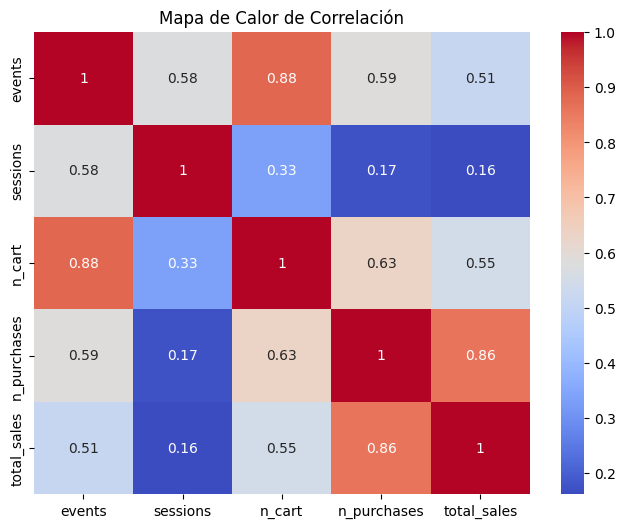

In [7]:
correlation_matrix = agg_users.loc[:,['events', 'sessions', 'n_cart', 'n_purchases', 'total_sales']].corr()
plt.figure(figsize=(8, 6))  # Adjust the figure size as per your preference
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación')

### Cargamos datos nuevos y probamos 

In [8]:
events_new_df = pd.read_csv(f"{base_path}/Data/events_complete.csv")
events_new_df = events_new_df[events_new_df["date"]>="2020-01-01"]

users = events_new_df["user_id"].unique()
unique_users = pd.DataFrame({"user_id":users, "p_baseline":np.random.uniform(size=len(users))})
unique_users["treatment"] = np.where(unique_users["p_baseline"]<=p_baseline,0,1)
events_new_df = events_new_df.merge(unique_users.loc[:,["user_id", "treatment"]], how="left", on="user_id")

events_new_df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view,treatment
0,2020-01-01 00:00:00 UTC,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a,2020-01-01 00:00:00+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0,0
1,2020-01-01 00:00:09 UTC,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a,2020-01-01 00:00:09+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0,1
2,2020-01-01 00:00:19 UTC,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,2020-01-01 00:00:19+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0,1
3,2020-01-01 00:00:24 UTC,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711,2020-01-01 00:00:24+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0,1
4,2020-01-01 00:00:25 UTC,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb,2020-01-01 00:00:25+00:00,2020-01-01,0.0,0.0,0.0,0.0,1.0,0


In [9]:
agg_users_new = (
    events_new_df
    .groupby("user_id")
    .agg(
        favorite_brand=("brand", lambda x: x.mode()),
        favorite_category=("category_id", lambda x: x.mode()),
        events=("product_id", "count"),
        sessions=("user_session", "nunique"),
        n_cart=("event_type_cart", "sum"),
        n_purchases=("event_type_purchase", "sum"),
        total_sales=("sales", "sum"),
    )
).reset_index()

agg_users_new["p_baseline"] = np.random.uniform(size=len(users))
agg_users_new["treatment"] = np.where(agg_users_new["p_baseline"]<=p_baseline,0,1)

agg_users_new = agg_users_new.merge(agg_users.loc[:,["user_id", "total_sales"]], on="user_id", how="left", suffixes=["", "_old"])
agg_users_new['previous_data'] = np.where(~agg_users_new["total_sales_old"].isna(), 1, 0)
agg_users_new['total_sales_old'].fillna(0, inplace=True)

agg_users_new

,user_id,favorite_brand,favorite_category,events,sessions,n_cart,n_purchases,total_sales,p_baseline,treatment,total_sales_old,previous_data
0,465496,cnd,1487580008447738866,3,2,0.0,0.0,0.0,0.873399,1,0.0,0
1,2038666,kims,1487580011534745720,1,1,0.0,0.0,0.0,0.171008,0,0.0,0
2,3571443,"[dewal, zinger]",1487580008112194531,2,1,0.0,0.0,0.0,0.445257,0,0.0,0
3,4230352,cnd,1487580005411062629,1,1,0.0,0.0,0.0,0.093121,0,0.0,0
4,4661182,grattol,1602943681873052386,20,6,0.0,0.0,0.0,0.491445,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
737088,622090016,runail,1487580009445982239,2,2,0.0,0.0,0.0,0.468820,0,0.0,0
737089,622090043,grattol,1602943681873052386,3,1,1.0,0.0,0.0,0.819289,1,0.0,0
737090,622090052,markell,"[1597770225539875791, 1783999072332415142]",2,2,0.0,0.0,0.0,0.980646,1,0.0,0
737091,622090098,metzger,1487580009336930331,1,1,0.0,0.0,0.0,0.792663,1,0.0,0


Text(0.5, 1.0, 'Mapa de Calor de Correlación')

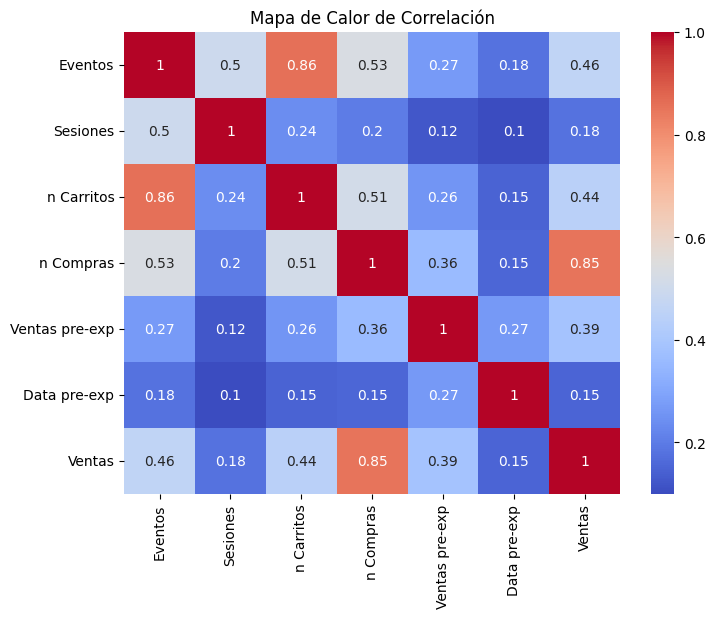

In [10]:
correlation_matrix_new = agg_users_new.loc[:,['events', 'sessions', 'n_cart', 'n_purchases', 'total_sales_old', 'previous_data', 'total_sales']].corr()
correlation_matrix_new.rename(index={"events":"Eventos", "sessions":"Sesiones", "n_cart":"n Carritos", "n_purchases":"n Compras", 
                                     "total_sales_old": "Ventas pre-exp", "previous_data": "Data pre-exp", "total_sales": "Ventas", }, 
                              columns={"events":"Eventos", "sessions":"Sesiones", "n_cart":"n Carritos", "n_purchases":"n Compras", 
                                     "total_sales_old": "Ventas pre-exp", "previous_data": "Data pre-exp", "total_sales": "Ventas",}, 
                                     inplace=True)
plt.figure(figsize=(8, 6))  # Adjust the figure size as per your preference
sns.heatmap(correlation_matrix_new, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación')

n Compras seems to be the better metric, unsorprisingly, but it is very unlikely that it won't be affected by a treatment. Seems better to use Ventas pre Experimento o Data pre-experimento

#### Test variance reduction alternatives

In [52]:
agg_users_new = agg_users_new.loc[:,["user_id", 'favorite_brand', 'favorite_category', 'events', 'sessions',
       'n_cart', 'n_purchases', 'p_baseline', 'treatment', 'total_sales', 'total_sales_old', 'previous_data']]

agg_users_new["p_baseline"] = np.random.uniform(size=len(users))
p_baseline = 0.5
agg_users_new["treatment"] = np.where(agg_users_new["p_baseline"]<=p_baseline,0,1)

agg_users_new['total_sales_sim'] = np.where(agg_users_new['treatment']==1, agg_users_new['total_sales']+0.1, agg_users_new['total_sales'])

agg_users_new.describe()

,user_id,events,sessions,n_cart,n_purchases,p_baseline,treatment,total_sales,total_sales_old,previous_data,total_sales_sim
count,7.370930e+05,737093.000000,737093.000000,737093.000000,737093.000000,7.370930e+05,737093.000000,737093.000000,737093.000000,737093.000000,737093.000000
mean,5.719660e+08,11.425199,2.566370,3.116319,0.686196,4.997906e-01,0.499607,3.429451,2.403959,0.149636,3.479412
std,7.031984e+07,55.055116,12.539051,18.403359,4.512149,2.885783e-01,0.500000,22.025436,21.585879,0.356715,22.025533
min,4.654960e+05,1.000000,0.000000,0.000000,0.000000,5.058923e-07,0.000000,-12.830000,0.000000,0.000000,-12.730000
25%,5.640086e+08,1.000000,1.000000,0.000000,0.000000,2.498015e-01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.006390e+08,2.000000,1.000000,0.000000,0.000000,4.996276e-01,0.000000,0.000000,0.000000,0.000000,0.100000
75%,6.103997e+08,4.000000,2.000000,0.000000,0.000000,7.496535e-01,1.000000,0.000000,0.000000,0.000000,0.100000
max,6.220902e+08,7910.000000,4139.000000,3850.000000,461.000000,9.999978e-01,1.000000,1850.400000,2497.860000,1.000000,1850.500000


In [53]:
simple_diff = smf.ols('total_sales_sim ~ treatment', data=agg_users_new).fit()
simple_diff.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.4117,0.036,94.072,0.000,3.341,3.483
treatment,0.1356,0.051,2.643,0.008,0.035,0.236


In [59]:
autorregression = smf.ols('total_sales_sim ~ total_sales_old + previous_data + treatment', data=agg_users_new).fit()
autorregression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0318,0.035,58.336,0.000,1.964,2.100
total_sales_old,0.3809,0.001,335.551,0.000,0.379,0.383
previous_data,3.1040,0.069,45.183,0.000,2.969,3.239
treatment,0.1349,0.047,2.855,0.004,0.042,0.228


In [60]:
autorregression.summary().tables[0]

Dep. Variable:,total_sales_sim,R-squared:,0.152
Model:,OLS,Adj. R-squared:,0.152
Method:,Least Squares,F-statistic:,4.400e+04
Date:,"Wed, 21 Jun 2023",Prob (F-statistic):,0.00
Time:,15:35:28,Log-Likelihood:,-3.2644e+06
No. Observations:,737093,AIC:,6.529e+06
Df Residuals:,737089,BIC:,6.529e+06
Df Model:,3,,
Covariance Type:,nonrobust,,


In [61]:
autorregression = smf.ols('total_sales_sim ~ total_sales_old + treatment', data=agg_users_new).fit()
autorregression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.4618,0.034,73.378,0.000,2.396,2.528
total_sales_old,0.3946,0.001,359.985,0.000,0.392,0.397
treatment,0.1383,0.047,2.923,0.003,0.046,0.231


In [62]:
autorregression.summary().tables[0]

Dep. Variable:,total_sales_sim,R-squared:,0.150
Model:,OLS,Adj. R-squared:,0.150
Method:,Least Squares,F-statistic:,6.480e+04
Date:,"Wed, 21 Jun 2023",Prob (F-statistic):,0.00
Time:,15:35:34,Log-Likelihood:,-3.2654e+06
No. Observations:,737093,AIC:,6.531e+06
Df Residuals:,737090,BIC:,6.531e+06
Df Model:,2,,
Covariance Type:,nonrobust,,


In [63]:
agg_users_new['total_sales_sim_tilde'] = smf.ols('total_sales_sim ~ total_sales_old', 
                                                     data=agg_users_new).fit().resid + np.mean(agg_users_new['total_sales_sim'])
cuped = smf.ols('total_sales_sim_tilde ~ treatment', data=agg_users_new).fit()
cuped.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.4103,0.033,101.966,0.000,3.345,3.476
treatment,0.1383,0.047,2.923,0.003,0.046,0.231


In [ ]:
metrics = agg_users_new.groupby("previous_data").agg(n_users=('user_id','count'), avg_sale=('total_sales','mean'), std_sale=('total_sales','std'),
                                                     avg_sale_old=('total_sales_old','mean'), std_sale_old=('total_sales_old','std'))
metrics

,n_users,avg_sale,std_sale,avg_sale_old,std_sale_old
previous_data,,,,,
0,626797,2.049208,15.694092,0.000000,0.000000
1,110296,11.273188,42.070628,16.065327,53.799894


Similar tanto ANCOVA como CUPED, con ambos casos con reducción de varianza. La mejor variables parece ser las ventas pre experimento, con la variable de si tiene data previa explicando poco (r**2~0.02 vs 0.15)

#### Test with bad randomization

In [72]:
agg_users_new = agg_users_new.loc[:,["user_id", 'favorite_brand', 'favorite_category', 'events', 'sessions',
       'n_cart', 'n_purchases', 'p_baseline', 'treatment', 'total_sales', 'total_sales_old', 'previous_data']]

agg_users_new["p_baseline"] = np.random.uniform(size=len(users)) + agg_users_new["previous_data"] / 10
p_baseline = np.median(agg_users_new["p_baseline"])
agg_users_new["treatment"] = np.where(agg_users_new["p_baseline"]<=p_baseline,0,1)

agg_users_new['total_sales_sim'] = np.where(agg_users_new['treatment']==1, agg_users_new['total_sales']+0.1, agg_users_new['total_sales'])

agg_users_new.describe()

,user_id,events,sessions,n_cart,n_purchases,p_baseline,treatment,total_sales,total_sales_old,previous_data,total_sales_sim
count,7.370930e+05,737093.000000,737093.000000,737093.000000,737093.000000,737093.000000,737093.000000,737093.000000,737093.000000,737093.000000,737093.000000
mean,5.719660e+08,11.425199,2.566370,3.116319,0.686196,0.514993,0.499999,3.429451,2.403959,0.149636,3.479451
std,7.031984e+07,55.055116,12.539051,18.403359,4.512149,0.291087,0.500000,22.025436,21.585879,0.356715,22.026067
min,4.654960e+05,1.000000,0.000000,0.000000,0.000000,0.000002,0.000000,-12.830000,0.000000,0.000000,-12.730000
25%,5.640086e+08,1.000000,1.000000,0.000000,0.000000,0.264987,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.006390e+08,2.000000,1.000000,0.000000,0.000000,0.515018,0.000000,0.000000,0.000000,0.000000,0.100000
75%,6.103997e+08,4.000000,2.000000,0.000000,0.000000,0.765023,1.000000,0.000000,0.000000,0.000000,0.100000
max,6.220902e+08,7910.000000,4139.000000,3850.000000,461.000000,1.099991,1.000000,1850.400000,2497.860000,1.000000,1850.500000


In [73]:
simple_diff = smf.ols('total_sales_sim ~ treatment', data=agg_users_new).fit()
simple_diff.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.1767,0.036,87.563,0.000,3.106,3.248
treatment,0.6056,0.051,11.803,0.000,0.505,0.706


In [76]:
autorregression = smf.ols('total_sales_sim ~ total_sales_old + previous_data + treatment', data=agg_users_new).fit()
autorregression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0386,0.034,59.259,0.000,1.971,2.106
total_sales_old,0.3809,0.001,335.550,0.000,0.379,0.383
previous_data,3.1018,0.069,45.037,0.000,2.967,3.237
treatment,0.1218,0.047,2.571,0.010,0.029,0.215


In [77]:
agg_users_new['total_sales_sim_tilde'] = smf.ols('total_sales_sim ~ total_sales_old + previous_data', 
                                                     data=agg_users_new).fit().resid + np.mean(agg_users_new['total_sales_sim'])
cuped = smf.ols('total_sales_sim_tilde ~ treatment', data=agg_users_new).fit()
cuped.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.4189,0.033,102.323,0.000,3.353,3.484
treatment,0.1211,0.047,2.564,0.010,0.029,0.214


### Sample Size estimation

In [37]:
np.random.seed(42)
agg_users_new = agg_users_new.loc[:,["user_id", 'favorite_brand', 'favorite_category', 'events', 'sessions',
       'n_cart', 'n_purchases', 'p_baseline', 'treatment', 'total_sales', 'total_sales_old', 'previous_data']]

agg_users_new["p_baseline"] = np.random.uniform(size=len(users))
p_baseline = 0.5
agg_users_new["treatment"] = np.where(agg_users_new["p_baseline"]<=p_baseline,0,1)
agg_users_new_baseline = agg_users_new.loc[agg_users_new["treatment"]==0,:]

agg_users_new_baseline['total_sales_tilde'] = smf.ols('total_sales ~ total_sales_old', 
                                                     data=agg_users_new_baseline).fit().resid + np.mean(agg_users_new_baseline['total_sales'])

agg_users_new_baseline.describe()

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_46176/2307806533.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_users_new_baseline['total_sales_tilde'] = smf.ols('total_sales ~ total_sales_old',


,user_id,events,sessions,n_cart,n_purchases,p_baseline,treatment,total_sales,total_sales_old,previous_data,total_sales_tilde
count,3.683680e+05,368368.000000,368368.000000,368368.000000,368368.000000,3.683680e+05,368368.0,368368.000000,368368.000000,368368.000000,368368.000000
mean,5.719911e+08,11.383855,2.569528,3.101276,0.676671,2.502482e-01,0.0,3.395981,2.390215,0.148827,3.395981
std,7.035241e+07,55.255396,13.460765,18.521118,4.431210,1.442365e-01,0.0,21.452882,21.591685,0.355918,19.663436
min,4.654960e+05,1.000000,0.000000,0.000000,0.000000,5.188446e-07,0.0,-4.760000,0.000000,0.000000,-492.266435
25%,5.641128e+08,1.000000,1.000000,0.000000,0.000000,1.255260e-01,0.0,0.000000,0.000000,0.000000,0.949548
50%,6.006456e+08,2.000000,1.000000,0.000000,0.000000,2.503586e-01,0.0,0.000000,0.000000,0.000000,0.949548
75%,6.104240e+08,4.000000,2.000000,0.000000,0.000000,3.749509e-01,0.0,0.000000,0.000000,0.000000,0.949548
max,6.220901e+08,7910.000000,4139.000000,3651.000000,461.000000,4.999997e-01,0.0,1843.320000,2497.860000,1.000000,1844.269548


We can see we have the same mean with a lower variance

In [48]:
for c in ["total_sales", "total_sales_tilde"]:
    agg_users_new_baseline[f"{c}_sq"] = agg_users_new_baseline.loc[:,c]**2

metrics = agg_users_new_baseline.agg({
    "user_id": "count",
    "total_sales": "sum",
    "total_sales_tilde": "sum",
    "total_sales_sq": "sum",
    "total_sales_tilde_sq": "sum",
})

this_line=pd.DataFrame({"n_users": [metrics["user_id"]], 
                            "sales_mean":[metrics["total_sales"]/metrics["user_id"]],
                            "sales_sd":[((metrics["total_sales_sq"]/metrics["user_id"])-(metrics["total_sales"]/metrics["user_id"])**2)**(1/2)],
                            "sales_tilde_mean":[metrics["total_sales_tilde"]/metrics["user_id"]],
                            "sales_tilde_sd":[((metrics["total_sales_tilde_sq"]/metrics["user_id"])-(metrics["total_sales_tilde"]/metrics["user_id"])**2)**(1/2)],
                            })

for m in ["sales", "sales_tilde"]:
    this_line[f"{m}_cv"] = this_line[f"{m}_sd"]/this_line[f"{m}_mean"]

this_line

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_46176/67888241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_users_new_baseline[f"{c}_sq"] = agg_users_new_baseline.loc[:,c]**2


,n_users,sales_mean,sales_sd,sales_tilde_mean,sales_tilde_sd,sales_cv,sales_tilde_cv
0,368368.0,3.395981,21.452853,3.395981,19.663409,6.317129,5.790199


Text(0.5, 1.0, 'Mínimo efecto detectable con 8 semanas de experimentación')

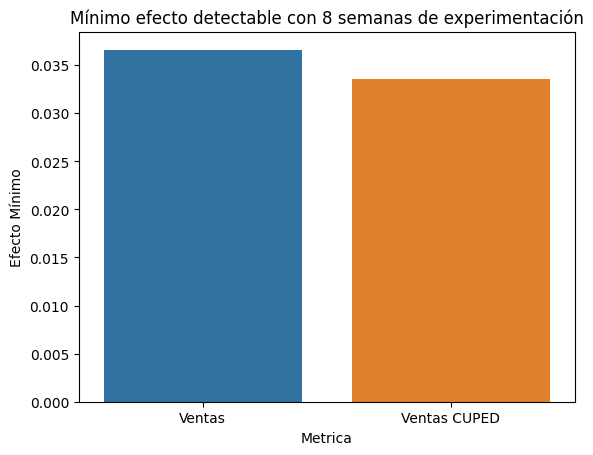

In [49]:
alpha = 0.05
power = 0.8
ratio = 1
effects_dict = {}

effect = zt_ind_solve_power(nobs1=this_line["n_users"][0], alpha=alpha, power=power, ratio=ratio, alternative="larger")
for m in ["sales", "sales_tilde"]:
    rel_effect = effect*this_line[f"{m}_cv"][0]
    effects_dict[m] = rel_effect

df = pd.DataFrame.from_dict(effects_dict, orient='index', columns=['Efecto Mínimo'])
df.reset_index(inplace=True)
df.rename(columns={'index': 'Metrica'}, inplace=True)
df.replace({"sales":"Ventas", "sales_tilde":"Ventas CUPED"}, inplace=True)

# Plot barplot using seaborn
sns.barplot(x='Metrica', y='Efecto Mínimo', data=df)
plt.title("Mínimo efecto detectable con 8 semanas de experimentación")

Text(0.5, 1.0, 'Días necesarios para detectar un efecto del 4%')

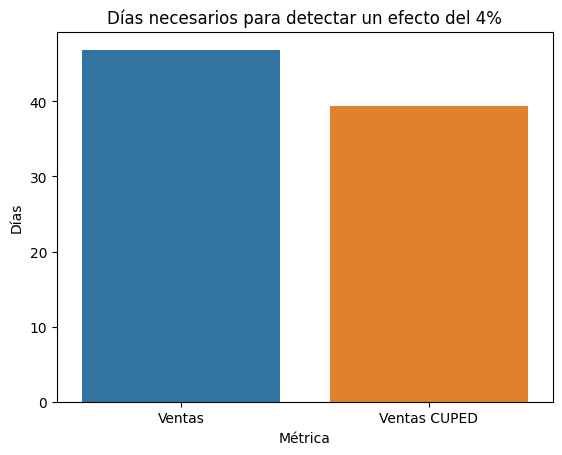

In [50]:
rel_effect = 0.04
days_dict = {}

for m in ["sales", "sales_tilde"]:
    effect = rel_effect/this_line[f"{m}_cv"][0]
    n_1 = zt_ind_solve_power(effect_size=effect, alpha=alpha, power=power, ratio=ratio, alternative="larger")
    days_dict[m] = n_1 / this_line["n_users"][0] * 56

df = pd.DataFrame.from_dict(days_dict, orient='index', columns=['Días'])
df.reset_index(inplace=True)
df.rename(columns={'index': 'Métrica'}, inplace=True)
df.replace({"sales":"Ventas", "sales_tilde":"Ventas CUPED"}, inplace=True)

# Plot barplot using seaborn
sns.barplot(x='Métrica', y='Días', data=df)
plt.title(f"Días necesarios para detectar un efecto del {int(rel_effect*100)}%")